# Identical network from C-elegans

Data from: https://arxiv.org/abs/1112.5507

In this paper they align shuffled identical networks from a C.elegans connectome using their Fast Approximate Quadratic Programming.

In this notebook we align sucessively 10 connectome networks using our Probabilistic Graph alignment network (because in the paper they aligned only pair of networks). For the succesive alignment we start aligning a pair of networks; once is thermalized, we add another network, and so on


In [1]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

# DATASET

In [2]:
d_store = pickle.load(open("agap_matrices.pickle", "rb"))
A_matrices = d_store["Matrices"]
P_agap = d_store["Permus"] 
L_blue = d_store["Matrix_blueprint"]

epochs = A_matrices.shape[0]
Nx = A_matrices.shape[1]

In [3]:
tablas = epochs + 1
rows, columns = Nx, Nx
M = np.zeros((tablas,rows,columns))

## Permutation for perfect alignment (networks were shuffled)
P_good = np.zeros((tablas, rows))

M[0,:,:] = L_blue.copy()
P_good[0,:] = np.arange((rows))+1
for i in range(1, tablas):
    M[i,:,:] = A_matrices[i-1,:,:].copy()
    P_good[i,:] = P_agap[i-1,:].copy()
P_good = P_good-1

#In case they are not square (we fill with zeros if not)
M_square = np.zeros((tablas, rows, rows))
M_square[:,:, 0:columns] = M[:,:,:]

# Binary networks
M_bin = np.zeros((tablas,rows,columns))
M_square_bin = np.zeros((tablas,rows,rows))
for i in range(tablas):
    for j in range(rows):
        for k in range(columns):
            if (M[i,j,k] >= 1):
                M_bin[i,j,k] = 1
                M_square_bin[i,j,k] = 1


### GROUP INFORMATION

In this database there is no group information

## ENERGY FUNCTIONS



In [13]:
@jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):

    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    return H
    
    
@jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K))
    ovlp_1 = np.zeros((K))
    for k in range(0,K):
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])  
                
                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c]
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A
                
                
    ovlp_1 = int(sum(ovlp_1))
    ovlp_0 = int(sum(ovlp_0))
    return ovlp_0, ovlp_1


@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f):
    
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
        
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2]
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew ) 
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
    
    return L_new_f


#### Some algorithm for sorting
@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_nogroups(L_f, A_f): 
    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]    
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    # First we order the blueprint and after the observations
    # Blueprint:
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size
        
    array_L = np.arange(Nx) #For the labels 
    quicksort(orden_L, array_L)

    #Observations: 
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #For the labels 
        quicksort(orden_A, array_A)    

    # Now ordered together both label array  array_L = [0,1,2,3...]
        array_A = array_A[np.argsort(array_L)]
        P_f[i,:] = array_A
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy() 
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo



## INITIAL CONDITIONS


In [14]:
Nx = rows # Nodes
K = 10 # Number of networks
alpha,beta = 5,2 # Values for the beta prior distribution 


Edges = Nx*Nx 
micropasos = Edges*K #Microsteps for each MCMC
A = np.zeros((K,Nx,Nx))
A = M_square_bin[:K, :,:].copy()

## INITIALIZATION ##

L_ini = np.zeros((Nx,Nx))
P_ini_0 = np.zeros((K,Nx))
P_inv_ini_0 = np.zeros((K,Nx))

# We inizialize with the Blueprint = L2
L_ini = (A[0,:,:]).copy()
        
## Overlaps
ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A,P_inv_ini_0)

P_good_k = np.zeros((K,Nx))
P_inv_good_k = P_good[:K,:].copy()  # En realidad en mi programa era la invversa!
P_good_k = np.zeros((K,Nx))
for m1 in range(K):
    for i_inv in range(0,Nx):
        for j_inv in range(0,Nx):
            if (P_inv_good_k[m1, i_inv] == j_inv):
                P_good_k[m1,j_inv] = i_inv
        
# Inizialization according to node-degree (taking into account group labels)
P_inis = permu_nogroups(L_ini, A)
P_inis = P_inis.astype(int)
P_ini_0 = (P_inis[0,:,:]).copy() # Mapping L to A
P_inv_ini_0 = (P_inis[1,:,:]).copy() # Mapping A to L
print('*************************')
print(P_ini_0[:,:10])

*************************
[[  0   1   2   3   4   5   6   7   8   9]
 [160 259  17   2  84 188  99  91 106 255]
 [191  53 231 184 195  22 207 146  89 152]
 [ 82  47 277  17 115 228  75 237  69  37]
 [  8 151 148 168 180  90 174  30 230  23]
 [ 57 184 238 226 112  82  23  24  76 161]
 [142 138 154 178  18 198 160  50  32 185]
 [178  39  20 186 159  66 126 129 136  41]
 [276 269   9 102 212  63 190  25 119  22]
 [147 249 142 185 243  77 216 179  55 252]]


## Temperatures

We are permorfing a Parallel tempering Markov Chain MonteCarlo

We run our MCMC at difference temperatures (proposing changes between them), and we will sample at temper = 1

In [16]:
# Temperature distributin
beta_o = 1.03
total = 15 # Odd name, in order to have beta = 1
b_exp = np.linspace(-5,5,num = total)
tempers = beta_o**b_exp # Account for 1/KT, called beta in thermodinamics
print('betas:', tempers)
N_t = len(tempers)

## Inizialitation of the system for each temperature, with the same mappings
P_ini_t = np.zeros((N_t,K,Nx))
P_inv_ini_t = np.zeros((N_t,K,Nx))
L_ini_t = np.zeros((N_t,Nx,Nx)) 

for i in range(0,N_t): 
    P_ini_t[i,:,:] = P_ini_0[:,:].copy()
    P_inv_ini_t[i,:,:] = P_inv_ini_0[:,:].copy()
    L_ini_t[i,:,:] = L_ini.copy()


betas: [0.86260878 0.88101504 0.89981405 0.91901419 0.93862401 0.95865228
 0.9791079  1.         1.0213379  1.0431311  1.06538932 1.08812249
 1.11134073 1.1350544  1.15927407]


# MONTE CARLO FUNCTIONS 

Probably some functions are easy to optimize.


In [17]:
### Some functions that numba do not have
@njit
def concatenate_numba_sinrep(a,b):
    size_a, size_b = len(a), len(b)
    no_double = []
    for i_b in range(size_b):
        if b[i_b] in a:
            size_b = size_b-1
        else:
            no_double.append(b[i_b])
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = no_double
    
    return a

@njit
def concatenate_numba(a,b):
    size_a, size_b = len(a), len(b)
    size = size_a + size_b
    c = np.zeros((size))
    c[0:size_a] = a
    c[size_a:] = b 
    
    return c

@njit
def sum_numba(S):
    Nx = S.shape[0]
    Ny = S.shape[1]
    
    suma = 0
    for i_s in range(Nx):
        suma = suma + sum(S[i_s,:])
        
    return suma
@njit
def sum_numba_filas(S): # 2 dimensions
    Nx = S.shape[0]
    Ny = S.shape[1]
    suma = np.zeros((Nx))
    for i_s in range(Nx):
        suma_c = 0 # sum of the column
        for i_y in range(Ny):
            suma[i_s] = suma_c + S[i_y,i_s] 
        
    return suma

@njit
def numba_choice():
    random_val = random.randint(0, 1)  # Generate a random integer between 0 and 1
    return 2 * random_val - 1

In [18]:
## Energy functions for the changes during the MonteCarlo

@jit(nopython=True)
def overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2,A_f, P_inv_old, i_change, j_change,pp1, pp2): 

    Nx = L_f_v1v2_old.shape[1]
    K = A_f.shape[0]
    
    ovlp_0_new , ovlp_1_new = 0,0
    ovlp_0_old , ovlp_1_old = 0,0
    ovlp_0_dif, ovlp_1_dif = 0,0
  
    #old and new: changes and mapping changes
    changes = np.array([i_change, j_change], dtype = np.int32)
    changes_p = np.array([pp1, pp2], dtype = np.int32)  
    changes_p_old = np.array([pp2, pp1], dtype = np.int32)
    
    for i_k in range(K):
        for i_chan,change in enumerate(changes):
            for i_x in range(Nx):
                if (i_k != m1): # Only changes in the networks m1
                    p_f = int(P_inv_old[i_k,change])
                    p_c = int(P_inv_old[i_k,i_x])
                    p_old, p_old_c = p_f, p_c
                
                else:
                    p_f = changes_p[i_chan]
                    p_old = changes_p_old[i_chan]
                    if (i_x == i_change):
                        p_c = pp1
                        p_old_c = pp2
                    elif(i_x == j_change):
                        p_c = pp2
                        p_old_c = pp1
                    else: # Only changes in the nodes i,j
                        p_c = int(P_inv_old[i_k, i_x])
                        p_old_c = p_c

                ## rows
                valor_L_old, valor_A_old = L_f_v1v2_old[i_chan,i_x], A_f[i_k,p_old,p_old_c]   
                valor_L_new, valor_A_new = L_f_v1v2[i_chan,i_x], A_f[i_k,p_f,p_c]
                ## columns
                valor_L_old_c, valor_A_old_c = 0,0
                valor_L_new_c, valor_A_new_c = 0,0
                column = 0        
                if (i_x not in changes):
                    column = 1
                    valor_L_old_c, valor_A_old_c = L_c_v1v2_old[i_chan,i_x],A_f[i_k,p_old_c, p_old]
                    valor_L_new_c, valor_A_new_c = L_c_v1v2[i_chan,i_x], A_f[i_k,p_c,p_f]

                ovlp_1_old = ovlp_1_old + valor_L_old*valor_A_old + valor_L_old_c*valor_A_old_c*column
                ovlp_0_old = ovlp_0_old + (1-valor_L_old)*(1-valor_A_old) + (1-valor_L_old_c)*(1-valor_A_old_c)*column
                
                ovlp_1_new = ovlp_1_new + valor_L_new*valor_A_new + valor_L_new_c*valor_A_new_c*column
                ovlp_0_new = ovlp_0_new + (1-valor_L_new)*(1-valor_A_new) + (1-valor_L_new_c)*(1-valor_A_new_c)*column
                
    ovlp_1_def = ovlp_1_new - ovlp_1_old
    ovlp_0_def = ovlp_0_new- ovlp_0_old
    
    
    return ovlp_0_def, ovlp_1_def

@jit(nopython=True)
def L_wiring_change_filas(m1,L_old,A_f, i_change, j_change, P_inv_old):
    
    Nx = A_f.shape[1]
    K = A_f.shape[0] 
    
    L_new_f = L_old.copy()
    L_f_v1v2,L_c_v1v2  = np.zeros((2,Nx)),np.zeros((2,Nx))
    
    ## changes
    changes = np.array([i_change, j_change])
    changes_new = np.array([j_change, i_change])
    
    ## Old values
    suma_old =(np.sum(L_old[i_change,:]) + np.sum(L_old[j_change,:]) + np.sum(L_old[:,i_change]) + np.sum(L_old[:,j_change]))-L_old[i_change,j_change]-L_old[j_change,j_change]-L_old[i_change,i_change]-L_old[j_change,i_change]
    
    ## New row and column
    L_new_f[i_change,:], L_new_f[j_change,:], L_new_f[:,i_change], L_new_f[:,j_change] = np.zeros(Nx),np.zeros(Nx),np.zeros(Nx),np.zeros(Nx)
    

    suma_1 = 0
    ## ROWS
    for i_i,i_chan in enumerate(changes): #Only looking at the 
        for i_x in range(Nx):
            if (i_x not in changes): # The rest of nodes
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                    else:
                        chan_new = changes[i_i]
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    
                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]

            else: # The nodes that change
                for k in range(K):
                    if (k == m1):
                        chan_new = changes_new[i_i]
                        
                        if (i_x == changes_new[0]):
                            p2_2 = int(P_inv_old[k,changes_new[1]])
                        else:
                            p2_2 = int(P_inv_old[k,changes_new[0]])
                    else:
                        chan_new = changes[i_i]
                        p2_2 = int(P_inv_old[k,i_x])
                    p1_2 = int (P_inv_old[k,chan_new])

                    L_f_v1v2[i_i,i_x] += A_f[k,p1_2,p2_2]
                    
            valor_lnew_2=1/K*  L_f_v1v2[i_i,i_x]
            L_f_v1v2[i_i,i_x] = round( valor_lnew_2 )
            
                    
    ## COLUMNS 
    for j_j,j_chan in enumerate(changes):
        for i_x in range(Nx):
            changes_x = 0
            if (i_x not in changes):
                for k in range(K):
                    
                    if (k == m1):
                        chan_new = changes_new[j_j]
                    else:
                        chan_new = changes[j_j]
                        
                    p1_2 = int (P_inv_old[k,chan_new])
                    p2_2 = int(P_inv_old[k,i_x])
                    L_c_v1v2[j_j,i_x] += A_f[k,p2_2,p1_2]
                
                valor_lnew_2=1/K* L_c_v1v2[j_j,i_x]
                L_c_v1v2[j_j,i_x] = round( valor_lnew_2)

                    
            else: # the changes are the same as the columns
                changes_x = 1
                if (i_x == j_chan):
                    L_c_v1v2[j_j,i_x] =  L_f_v1v2[j_j,i_x]
                else:
                    i_x_inv = changes[j_j]
                    if (j_j  == 0):
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[1,i_x_inv]

                    else:
                        L_c_v1v2[j_j,i_x] =  L_f_v1v2[0,i_x_inv]
           
    suma_new = np.sum(L_f_v1v2[0,:]) + np.sum(L_f_v1v2[1,:]) + np.sum(L_c_v1v2[0,:]) + np.sum(L_c_v1v2[1,:])-L_c_v1v2[0,j_change]-L_c_v1v2[0,i_change]-L_c_v1v2[1,j_change]-L_c_v1v2[1,i_change]
    suma_1 = suma_new - suma_old
    return L_f_v1v2,L_c_v1v2, suma_1

In [24]:
@jit(nopython = True)
def parallel_L_knwn_change_capa(n_capas,c_parallel,alpha,beta,fijado_f,groups_f,
                       A, P_t_f, P_inv_t_f, L_t_f,suma_L, Energy_t_f, ovlp_t_f0, ovlp_t_f1, tempers_f):
    
    # fijado_f : To let one of the networks fixed or not (If only two networks it doesn't matter)
    # c_parallel: counter to change temperatures
    # start_f, end,f
    # N_groups_f: Number of groups
    # groups_f: Directly the ggroup numbeer from the position
    
    ### Movement:
    # 1) Choose two random nodes
    # 2) Each 4 movements, we propose change the temperatures

    N_t = L_t_f.shape[0] # Numbers of tempers
    Nx = L_t_f.shape[1] # Numbers of nodes
    K = n_capas # Numbers of networks
    Edges_sum = K*Nx*Nx
   
    if (c_parallel <4*Nx): # If not change of temperatures
        c_parallel += 1
        
        #One each two movements always in the new networks
        if (c_parallel & 1): 
            m1 = (K-1)
        #Choose the networks to propose the change (in all temperatures)
        if (fijado_f == 1):
            m1 = np.random.randint(K-1)+1 #One networks
        else:
            m1 = np.random.randint(K)    
        
        for k_nt in range(N_t):            
            # 1) Choose a random node (node in A)
            v1_mapping = np.random.randint(0, Nx)

            v2_mapping = np.random.randint(0, Nx)
            while (v2_mapping == v1_mapping):
                v2_mapping = np.random.randint(0, Nx)

            # Nodes in L
            v1 = P_t_f[k_nt, m1,v1_mapping]
            v2 = P_t_f[k_nt, m1, v2_mapping]


            ### Only changes in the specific columns and rows
            L_f_v1v2, L_f_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))
            L_c_v1v2, L_c_v1v2_old = np.zeros((2,Nx)),np.zeros((2,Nx))

            pp_1 = int(P_inv_t_f[k_nt,m1,v2]) # v2_mapping
            pp_2 = int(P_inv_t_f[k_nt,m1,v1]) # v1_mapping
            
            # Changes in the blueprint
            L_f_v1v2,L_c_v1v2 , suma_aux = L_wiring_change_filas(m1,L_t_f[k_nt,:,:], A[:n_capas,:,:], v1, v2, P_inv_t_f[k_nt,:n_capas,:])
            L_f_v1v2_old[0,:],L_f_v1v2_old[1,:] = L_t_f[k_nt,v1,:],L_t_f[k_nt,v2,:]
            L_c_v1v2_old[0,:],L_c_v1v2_old[1,:] = L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2]
            
            # Parameters to change
            Edges_L = K*(suma_L[k_nt] + suma_aux)
            Edges_NoL = Edges_sum - Edges_L
            ovl_0_new, ovl_1_new = overlap_total_change_filas(m1,L_f_v1v2_old,L_c_v1v2_old,L_f_v1v2,L_c_v1v2 ,A[:n_capas,:,:],P_inv_t_f[k_nt,:n_capas,:], v1,v2, pp_1, pp_2)
            overlap_0,overlap_1 = ovlp_t_f0[k_nt] + ovl_0_new, ovlp_t_f1[k_nt] + ovl_1_new
            Energy_bucle = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
            dE_sampler = Energy_bucle - Energy_t_f[k_nt]
            dE_t = dE_sampler

            ### UPDATE
            if (dE_t < 0):
                
                P_aux1 = P_t_f[k_nt, m1,pp_2]
                P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                P_t_f[k_nt, m1, pp_1] = P_aux1

                P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                P_inv_t_f[k_nt,m1,v1] = P_invaux1

                Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                ovlp_t_f0[k_nt] = overlap_0
                ovlp_t_f1[k_nt] = overlap_1
                L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                suma_L[k_nt] = suma_L[k_nt] + suma_aux

            elif (np.random.rand() < np.exp(-dE_t*tempers_f[k_nt])):

                P_aux1 = P_t_f[k_nt, m1,pp_2]
                P_t_f[k_nt, m1, pp_2] = P_t_f[k_nt, m1,pp_1]
                P_t_f[k_nt, m1, pp_1] = P_aux1

                P_invaux1 = P_inv_t_f[k_nt,m1,v2]
                P_inv_t_f[k_nt,m1,v2] = P_inv_t_f[k_nt,m1,v1]
                P_inv_t_f[k_nt,m1,v1] = P_invaux1

                Energy_t_f[k_nt] = Energy_t_f[k_nt] + dE_t
                ovlp_t_f0[k_nt] = overlap_0
                ovlp_t_f1[k_nt] = overlap_1
                L_t_f[k_nt,v1, :],L_t_f[k_nt,v2, :] = L_f_v1v2[0,:],L_f_v1v2[1,:]
                L_t_f[k_nt,:,v1],L_t_f[k_nt,:,v2] = L_c_v1v2[0,:],L_c_v1v2[1,:]
                suma_L[k_nt] = suma_L[k_nt] + suma_aux

    else: # Change in temperatures
        c_parallel = 0 
        
        ### Changes between adjacent temperatures
        mt1 = np.random.randint(N_t)  #temper 1
        mt2 =  mt1 + numba_choice()#temper 2
        while (mt1 == mt2):
            mt2 =  mt1 + numba_choice()
        if (mt2 == N_t ):
            mt2 = N_t-2

        Energy_1 = Energy_t_f[mt1]
        Energy_2 = Energy_t_f[mt2] 
        

        dE_parallel = -(tempers_f[mt1]-tempers_f[mt2])*(Energy_1-Energy_2)
        if (dE_parallel <0):
            P_aux1 = (P_t_f[mt1, :n_capas, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:n_capas,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:n_capas,:] = (P_t_f[mt2, :n_capas, :]).copy()
            P_inv_t_f[mt1,:n_capas,:] = (P_inv_t_f[mt2,:n_capas,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]

            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:n_capas,:] = P_aux1.copy()
            P_inv_t_f[mt2,:n_capas,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux

        elif (np.random.rand() < np.exp(-dE_parallel)):
            P_aux1 = (P_t_f[mt1, :n_capas, :]).copy()
            P_inv_aux1 = (P_inv_t_f[mt1,:n_capas,:]).copy()
            L_aux1 = (L_t_f[mt1,:,:]).copy()

            ovlp_aux0 = (ovlp_t_f0[mt1])
            ovlp_aux1 = (ovlp_t_f1[mt1])
            suma_aux = suma_L[mt1]

            # 1 --> 2
            Energy_t_f[mt1] = Energy_2
            P_t_f[mt1,:n_capas,:] = (P_t_f[mt2, :n_capas, :]).copy()
            P_inv_t_f[mt1,:n_capas,:] = (P_inv_t_f[mt2,:n_capas,:]).copy()
            L_t_f[mt1,:,:] = (L_t_f[mt2,:,:]).copy()

            ovlp_t_f0[mt1] = ovlp_t_f0[mt2]
            ovlp_t_f1[mt1] = ovlp_t_f1[mt2]
            suma_L[mt1] = suma_L[mt2]

            # 2 --> 1
            Energy_t_f[mt2] = Energy_1
            P_t_f[mt2,:n_capas,:] = P_aux1.copy()
            P_inv_t_f[mt2,:n_capas,:] = P_inv_aux1.copy()
            L_t_f[mt2,:,:] = L_aux1.copy()

            ovlp_t_f0[mt2] = ovlp_aux0
            ovlp_t_f1[mt2] = ovlp_aux1
            suma_L[mt2] = suma_aux

    return c_parallel, P_t_f, P_inv_t_f,Energy_t_f, ovlp_t_f0, ovlp_t_f1, L_t_f, suma_L, groups_f

In [25]:
## Once the system is thermalised, before adding the new networks,
## we initialize the other networks with the lowest energy found from the previous thermalisation

@njit
def less_energy( P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,suma_L_t):
    

    P_t_new, P_inv_t_new, Energy_t_new, ovlp_t0_new, ovlp_t1_new, L_t_new =  P_t.copy(), P_inv_t.copy(), Energy_t.copy(), ovlp_t0.copy(), ovlp_t1.copy(), L_t.copy()
    suma_L_t_new = suma_L_t.copy()
    N_t = P_t.shape[0]
    min_E = np.argmin(Energy_t)
    
    for k_nt in range(N_t):
        P_t_new[k_nt,:,:] = P_t[min_E,:,:].copy()
        P_inv_t_new[k_nt,:,:] = P_inv_t[min_E,:,:].copy()
        Energy_t_new[k_nt] = Energy_t[min_E]
        ovlp_t0_new[k_nt] = ovlp_t0[min_E]
        ovlp_t1_new[k_nt] = ovlp_t1[min_E]
        L_t_new[k_nt,:,:] = L_t[min_E,:,:].copy()
        suma_L_t_new[k_nt] = suma_L_t[min_E]

    return P_t_new, P_inv_t_new, Energy_t_new, ovlp_t0_new, ovlp_t1_new, L_t_new,suma_L_t_new

## adding new networks
@njit
def new_capa(P_t, P_inv_t, L_t, capa):
    N_t = P_t.shape[0]
    Energy_new,overlap_0_new, overlap_1_new = np.zeros((N_t)),np.zeros((N_t)),np.zeros((N_t))
    Edges_sum = capa*Nx*Nx
    for k_nt in range(N_t):
        Edges_L = capa*sum_numba((L_t[k_nt,:,:]))
        Edges_NoL = Edges_sum - Edges_L
        overlap_0_new[k_nt], overlap_1_new[k_nt] = overlap_total_prob(L_t[k_nt,:,:],A[:capa,:,:],P_inv_t[k_nt,:capa,:])
        Energy_new[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0_new[k_nt], overlap_1_new[k_nt],alpha, beta)

    return Energy_new, overlap_0_new, overlap_1_new

# Running MonteCarlo

In [26]:
fijado = 0 # To maintain fix the first network

In [27]:
P_new, P_inv_new = P_good_k.copy(), P_inv_good_k.copy()         
L_new = np.zeros((Nx,Nx)) 
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping all networks:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')
print('****************')

### 2 networks
capa = 2
Edges_sum = capa*Nx*Nx
Edges_L = capa*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A[:capa,:,:],P_inv_new[:capa,:])     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping 2 networks:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')



Energy with the reference mapping all networks: 47.065485622995766
overlap_0: 756470 /overlap_1: 21940
%Overlaps: 100.0 %
****************
Energy with the reference mapping 2 networks: 40.629796086977876
overlap_0: 151294 /overlap_1: 4388
%Overlaps: 100.0 %


In [28]:
np.random.seed( random.randint(1,1999))
P_new, P_inv_new = P_new, P_inv_new = P_good_k.copy(), P_inv_good_k.copy()             
L_new = np.zeros((Nx,Nx))
L_new =  L_wiring(A, P_inv_new)

Edges_sum = K*Nx*Nx
Edges_L = K*(sum(sum(L_new))) # edges=1 in A
Edges_NoL = Edges_sum - Edges_L # edges=0 in A
overlap_0, overlap_1 = overlap_total_prob(L_new,A,P_inv_new)     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')


### 2 networks
capa = 2
Edges_sum = capa*Nx*Nx
Edges_L = capa*(sum(sum(L_new))) # Los edges=1 que tiene la matriz A
Edges_NoL = Edges_sum - Edges_L #Los edges=0 que tiene la matriz A
overlap_0, overlap_1 = overlap_total_prob(L_new,A[:capa,:,:],P_inv_new[:capa,:])     
Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
print('Energy with the reference mapping 2 networks:', Energy_new)
print( 'overlap_0:', overlap_0,'/overlap_1:', overlap_1)
print('%Overlaps:',100*(overlap_0+overlap_1)/Edges_sum ,'%')



# VARIABLE USING INITIAL CONDITIONS
P_t = np.zeros((N_t,K,Nx))
P_inv_t = np.zeros((N_t,K,Nx))
L_t = np.zeros((N_t,Nx, Nx))
Energy_t, Energy_ini_t = np.zeros((N_t)), np.zeros((N_t))
Edges_L_t, Edges_NoL_t = np.zeros((N_t)), np.zeros((N_t))
groups_t = np.zeros((N_t, K, Nx))
ovlp_ini0_t = np.zeros((N_t)) + ovlp_ini0
ovlp_ini1_t = np.zeros((N_t)) + ovlp_ini1
ovlp_ini0_t, ovlp_ini1_t = ovlp_ini0_t.astype(int), ovlp_ini1_t.astype(int)
ovlp_t0, ovlp_t1 = np.zeros((N_t)) + ovlp_ini0, np.zeros((N_t)) + ovlp_ini1
P_t = (P_ini_t).copy()
P_inv_t = (P_inv_ini_t).copy()
L_t = (L_ini_t).copy()
groups_t = groups_ini_t.copy()
#Integer variables
ovlp_t0, ovlp_t1 = ovlp_t0.astype(int), ovlp_t1.astype(int)
P_t = P_t.astype(int)
P_inv_t = P_inv_t.astype(int)
L_t = L_t.astype(int)
groups_t = groups_t.astype(int)

## Initial energy with L = A[0]
Edges_L = capa*sum(sum(L_ini))
Edges_NoL = Edges_sum - Edges_L         
ovlp_ini0, ovlp_ini1 = overlap_total_prob(L_ini,A[:capa,:,:],P_inv_ini_0[:capa,:])
Energy_ini = hamiltonian_prob(Edges_NoL, Edges_L, ovlp_ini0, ovlp_ini1 ,alpha, beta)
Energy_ini_t = np.zeros((N_t))+ Energy_ini 
print()
print('Initial energy with L = A[0]:', Energy_ini)
print()


#### Now the Blueprint is averaged
for k_nt in range(N_t):
    L_t[k_nt,:,:] =  L_wiring(A[:capa,:,:], P_inv_t[k_nt,:capa,:])
    Edges_L_t[k_nt] = capa*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL_t[k_nt] = Edges_sum - Edges_L_t[k_nt]
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A[:capa,:,:],P_inv_t[k_nt,:capa,:])
    Energy_t[k_nt] = hamiltonian_prob(Edges_NoL_t[k_nt], Edges_L_t[k_nt], overlap_0, overlap_1,alpha, beta)
    ovlp_t0[k_nt], ovlp_t1[k_nt] = overlap_0, overlap_1
print('Energy with L_wiring:', Energy_t[0]) 
print('overlaps 0:', ovlp_t0[0], '1:', ovlp_t1[0])
print('%Overlaps:',100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')

Energy_ini_wiring = Energy_t.copy()
suma_L_t = np.zeros(N_t)
for k_nt in range(N_t):
    suma_L_t[k_nt] = sum_numba(L_t[k_nt,:,:])


### MONTE CARLO
# Parameters
PasosMC = np.zeros((K-1)) #Quito una por las parejas
PasosMC[0] = 2000
PasosMC[1:4] = 6000
PasosMC[4:K] = 8000
len(PasosMC.shape)
PasosMC = PasosMC.astype(int)
Long_corr =  200
Pasos_corr = 6000
Pasos_store = int((PasosMC[-1] - Pasos_corr)/Long_corr)
if (Pasos_store<0):
    Pasos_store = 0
    
# Variables to store    
energies_pasos = np.zeros((N_t,np.sum(PasosMC)))
energies_pasos[:,0] = Energy_ini_wiring
count_parallel, count_unl = 0, 0
P_store = np.zeros((Pasos_store,N_t, K, Nx))
Energy_store = np.zeros((Pasos_store, N_t))
L_store = np.zeros((Pasos_store,N_t, Nx, Nx))

#######################################
start = time.time()
count_parallel, count_long, i_long = 0,0,0
capa_in = 2
i_ener = -1
for i_capa,capa in enumerate(range(capa_in, K+1)):
    capa_old = capa-1
    print('Final de capa', capa_old, 'Energy', Energy_t)
    #Initialization lowest energy
    P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t, suma_L_t = less_energy(P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t, suma_L_t )
    Energy_t, ovlp_t0, ovlp_t1 = new_capa(P_t, P_inv_t, L_t, capa)
    print('Ini capa', capa, 'new energies:', Energy_t)
    Edges_sum = capa*Nx*Nx
    
    print()
    print('**********************')
    print('Reference energy:')
    Edges_sum = capa*Nx*Nx
    L_new = L_wiring(A[:capa,:,:], P_inv_new[:capa,:])
    Edges_L = capa*(sum(sum(L_new))) 
    Edges_NoL = Edges_sum - Edges_L 
    overlap_0, overlap_1 = overlap_total_prob(L_new,A[:capa,:,:],P_inv_new[:capa,:])     
    Energy_new = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta)
    print('Energy with the reference mapping',capa,' networks:', Energy_new)
    
    for i_mc in tqdm(range(0,PasosMC[i_capa])):
        i_ener += 1
        energies_pasos[:, i_ener] = Energy_t[:]
        # Starting to store sampling configurations
        if (capa == K): # Solo guardo la última
            
            if (i_mc > Pasos_corr):
                count_long += 1
                if (count_long == Long_corr):
                    count_long = 0
                    P_store[i_long,:,:,:] = P_t.copy()
                    Energy_store[i_long,:] = Energy_t.copy()
                    L_store[i_long,:,:,:] = L_t.copy()
                    i_long += 1
                    print('Step', i_mc, 'Energy (temper = 1):', Energy_t[4])

        
        for i_micro in range(Nx):

            count_parallel,P_t, P_inv_t, Energy_t, ovlp_t0, ovlp_t1, L_t,suma_L_t, groups_t = parallel_L_knwn_change_capa(capa, count_parallel,alpha,beta,fijado,groups_t, A, P_t,
                                                                                                    P_inv_t, L_t,suma_L_t, Energy_t, ovlp_t0,   ovlp_t1, tempers)


end = time.time()

print("Elapsed (after compilation) = %s" % (end - start))  

## Final energy
Edges_sum = capa*Nx*Nx
Energy_calculada = np.zeros((N_t))
for k_nt in range(N_t):
    Edges_L= capa*sum(sum(L_t[k_nt,:,:]))
    Edges_NoL = Edges_sum - Edges_L
    overlap_0, overlap_1 = overlap_total_prob(L_t[k_nt,:,:],A[:capa,:,:],P_inv_t[k_nt,:capa,:])
    Energy_calculada[k_nt] = hamiltonian_prob(Edges_NoL, Edges_L, overlap_0,overlap_1,alpha, beta)
    
print('Energy final:', Energy_t, '/Computed final:', Energy_calculada) 
print('overlaps_0:', ovlp_t0[0], 'overlap_1:', ovlp_t1[0], '%overlaps:', 100*(ovlp_t0[0] + ovlp_t1[0])/Edges_sum ,'%')



Energy with the reference mapping: 47.065485622995766
overlap_0: 756470 /overlap_1: 21940
%Overlaps: 100.0 %
Energy with the reference mapping 2 networks: 40.629796086977876
overlap_0: 151294 /overlap_1: 4388
%Overlaps: 100.0 %

Initial energy with L = A[0]: 14171.757531515519

Energy with L_wiring: 19411.433179493637
overlaps 0: 151294 1: 166
%Overlaps: 97.28806156138796 %
Final de capa 1 Energy [19411.43317949 19411.43317949 19411.43317949 19411.43317949
 19411.43317949 19411.43317949 19411.43317949 19411.43317949
 19411.43317949 19411.43317949 19411.43317949 19411.43317949
 19411.43317949 19411.43317949 19411.43317949]
Ini capa 2 new energies: [19411.43317949 19411.43317949 19411.43317949 19411.43317949
 19411.43317949 19411.43317949 19411.43317949 19411.43317949
 19411.43317949 19411.43317949 19411.43317949 19411.43317949
 19411.43317949 19411.43317949 19411.43317949]

**********************
Reference energy:
Energy with the reference mapping 2  networks: 40.629796086977876


  2%|▋                                        | 34/2000 [00:21<20:56,  1.57it/s]


SystemError: CPUDispatcher(<function parallel_L_knwn_change_capa at 0x7f594ac50280>) returned a result with an exception set

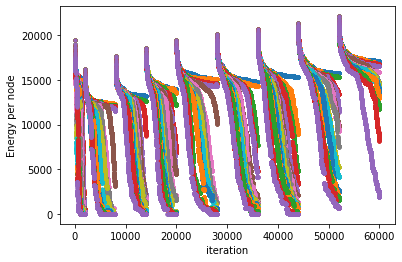

In [44]:
x=np.arange(len(energies_pasos[0,:]))
for k_nt in range(0,N_t):
    energies_pasos_temper = energies_pasos[k_nt,:] 
    plt.plot(x,energies_pasos_temper,'.',label='%s temper' % tempers[k_nt])
    plt.xlabel('iteration')
    plt.ylabel('Energy per node')
# plt.legend()
plt.show()

In [ ]:
# Voy a construir un diccionario para guardar todo
d_store={}
string = "QAP_succesive_2_10.pickle"
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups

d_store["E_store"] = Energy_store
d_store["L_store"] = L_store

d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr 

file1 = open(string,"wb")
pickle.dump( d_store, file1)
# prueba = pickle.load(open(string, "rb"))

In [ ]:
# Voy a construir un diccionario para guardar todo
d_store={}
d_store["Datos_energy"] = energies_pasos
d_store["Permus"] = P_t
d_store["Permus_inv"] = P_inv_t
d_store["Permusstore"] = P_store
d_store["L_latent"] = L_t
d_store["temper"] = tempers
d_store["A"] = A
d_store["start_groups"] = start_groups
d_store["end_groups"] = end_groups

d_store["E_store"] = Energy_store
d_store["L_store"] = L_store

d_store["E_groundtruth"] = Energy_new
d_store["Pasos_corr_ini"] = Pasos_corr 
d_store["Step_corr"] = Long_corr 

file1 = open(string,"wb")
pickle.dump( d_store, file1)
prueba = pickle.load(open(string, "rb"))
